# IMDB 영화평가 분류

In [1]:
# 패키지 로드
import warnings
warnings.filterwarnings(action="ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import contractions
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import nltk, re
from nltk.corpus import stopwords as stw

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer

2024-04-24 11:41:41.671442: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-24 11:41:41.671497: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-24 11:41:41.723261: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-24 11:41:41.829393: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-24 11:41:42.590050: W tensorflow/compiler/tf2

In [2]:
# 데이터 로드
origin = pd.read_excel("./data/imdb.xlsx")
origin.head()

,sentiment,review
0,positive,One of the other reviewers has mentioned that ...
1,positive,A wonderful little production. <br /><br />The...
2,positive,I thought this was a wonderful way to spend ti...
3,negative,Basically there's a family where a little boy ...
4,positive,"Petter Mattei's ""Love in the Time of Money"" is..."


In [3]:
# 종속변수 라벨링
df = origin.copy()

le = LabelEncoder()
df['sentiment'] = le.fit_transform(df['sentiment'])
print(le.classes_)
df.head()

['negative' 'positive']


,sentiment,review
0,1,One of the other reviewers has mentioned that ...
1,1,A wonderful little production. <br /><br />The...
2,1,I thought this was a wonderful way to spend ti...
3,0,Basically there's a family where a little boy ...
4,1,"Petter Mattei's ""Love in the Time of Money"" is..."


## 문자열 전처리

In [4]:
# 영어 불용어 로드
nltk.download("stopwords")
stopwords = list(stw.words("english"))
stopwords[:5]

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/yjg1005/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i', 'me', 'my', 'myself', 'we']

In [5]:
# 약어, 이메일주소, 태그문등 불필요한 데이터 제거
reviews = []

for i in df['review'].values:
    # 불용어 처리
    source = " ".join([w for w in i.split() if w not in stopwords])

    # 약어 처리
    source = contractions.fix(source)

    # email 제거
    source = re.sub(
            r"\b[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}\b", "", source
        )

    # html 태그 제거
    source = re.sub(r"<[^>]*>", "", source)

    # url 제거
    source = re.sub(
            r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+",
            "",
            source,
        )

    # 숫자 제거
    source = re.sub(r"\b[0-9]+\b", "", source)

    # 특수문자 제거
    x = re.sub(r"[^\w ]+", "", source)
    source = " ".join(x.split())
    
    reviews.append(source)

In [6]:
# 독립, 종속변수 정의
X = reviews.copy()
Y = df['sentiment']

In [7]:
# 텍스트 토큰화
tokenizer = Tokenizer(oov_token = '<OOV>')
tokenizer.fit_on_texts(X)
print(f"전체 단어수: {len(tokenizer.word_index)+1}")

token_set = tokenizer.texts_to_sequences(X)
print("토큰의 크기 :", len(token_set))

# 문장별로 <OOV>의 수 카운트
i = tokenizer.texts_to_sequences(X[:10])
for j in range(10):
    print(i[j].count(1))

전체 단어수: 216419
토큰의 크기 : 49998
0
0
0
0
0
0
0
0
0
0


In [8]:
# 단어별 빈도수 확인 (5개 까지)
bins = tokenizer.word_counts.items()
print(list(bins)[:5])

[('one', 50324), ('reviewers', 500), ('mentioned', 1026), ('watching', 8909), ('oz', 256)]


In [9]:
# 사용 빈도가 높다고 판단할 등장 회수
threshold = 30

# 전체 단어의 수
total_cnt = len(tokenizer.word_index)

# 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트할 값
rare_cnt = 0

# 훈련 데이터의 전체 단어 빈도수 총 합
total_freq = 0

# 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합
rare_freq = 0

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if value < threshold:
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print("단어 집합(vocabulary)의 크기 :", total_cnt)
print("등장 빈도가 %s번 미만인 희귀 단어의 수: %s" % (threshold, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt) * 100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq) * 100)

# 자주 등장하는 단어 집합의 크기 구하기 -> 이 값이 첫 번째 학습층의 input 수가 된다.
vocab_size = total_cnt - rare_cnt + 2
print("단어 집합의 크기 :", vocab_size)

단어 집합(vocabulary)의 크기 : 216418
등장 빈도가 30번 미만인 희귀 단어의 수: 201100
단어 집합에서 희귀 단어의 비율: 92.92203051502186
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 8.597505256648489
단어 집합의 크기 : 15320


In [10]:
# 자주 등장하는 단어 외는 OOV로 처리하여 토큰화 진행
tokenizer2 = Tokenizer(oov_token = '<OOV>', num_words = vocab_size)
tokenizer2.fit_on_texts(X)
print(f"전체 단어수: {len(tokenizer2.word_index) + 1}")

token_set = tokenizer2.texts_to_sequences(X)
print('토큰의 크기 :', len(token_set))

i = tokenizer2.texts_to_sequences(X[:10])

# 문장별로 <OOV>의 수 카운트
for j in range(10):
    print(i[j].count(1))

전체 단어수: 216419
토큰의 크기 : 49998
15
10
7
2
13
3
11
4
1
1


In [11]:
# 토큰화 결과 길이가 0인 문장 찾기
drop_target_index = []

for i, v in enumerate(token_set):
    if len(v) < 1:
        drop_target_index.append(i)

print("길이가 0인 항목의 수: ", len(drop_target_index))
print("길이가 0인 항목의 인덱스 모음: ", drop_target_index)

# 길이가 0인 데이터 삭제 (현 데이터에서는 없음)
token_set2 = np.asarray(token_set, dtype="object")

# 토큰 결과에서 해당 위치의 항목들을 삭제한다.
fill_token_set = np.delete(token_set2, drop_target_index, axis=0)

# 종속변수에서도 같은 위치의 항목들을 삭제해야 한다.
label_set = np.delete(Y, drop_target_index, axis=0)

print("독립변수(덧글) 데이터 수: ", len(fill_token_set))
print("종속변수(레이블) 데이터 수: ", len(label_set))

길이가 0인 항목의 수:  0
길이가 0인 항목의 인덱스 모음:  []
독립변수(덧글) 데이터 수:  49998
종속변수(레이블) 데이터 수:  49998


In [12]:
# 문장별로 몇개의 단어를 포함하고 있는지 확인
word_counts = []

for s in fill_token_set:
    word_counts.append(len(s))

count_df = pd.DataFrame({"count": word_counts})
count_df

,count
0,181
1,94
2,93
3,72
4,130
...,...
49993,98
49994,62
49995,122
49996,120


In [13]:
# 가장 많은 단어를 사용한 리뷰와 가장 적은 단어를 사용한 리뷰
max_word_count = max(word_counts)
min_word_count = min(word_counts)
print("가장 많은 단어를 사용하는 문장의 단어 수 :", max_word_count)
print("가장 적은 단어를 사용하는 문장의 단어수 :", min_word_count)

가장 많은 단어를 사용하는 문장의 단어 수 : 1508
가장 적은 단어를 사용하는 문장의 단어수 : 4


In [14]:
# 패딩
max_word_count = max(word_counts)
# max_word_count = 200
pad_token_set = pad_sequences(fill_token_set, maxlen=max_word_count)

#  원래 단어의 앞에 ‘지정해준 단어의 길이(max_word_count) – 원래 단어의 길이`만큼 0이 추가된 것을 볼 수 있다.
print("After pad_sequences: ", len(pad_token_set[0]), len(pad_token_set[1]))
print(pad_token_set[0][:50])

After pad_sequences:  1508 1508
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [15]:
# 데이터 분할
x_train, x_test, y_train, y_test = train_test_split(pad_token_set, Y, test_size = 0.2, random_state = 0)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(39998, 1508) (10000, 1508) (39998,) (10000,)


In [16]:
# 모델 생성 및 컴파일

# input_dim : 학습 데이터셋의 단어의 개수
# output_dim : 임베딩 벡터의 크기

model = Sequential([
    Embedding(input_dim = vocab_size, output_dim = 32, input_length = max_word_count),
    Flatten(),
    Dense(1, activation = 'sigmoid')
])

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1508, 32)          490240    
                                                                 
 flatten (Flatten)           (None, 48256)             0         
                                                                 
 dense (Dense)               (None, 1)                 48257     
                                                                 
Total params: 538497 (2.05 MB)
Trainable params: 538497 (2.05 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2024-04-24 11:05:34.315976: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22455 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:08:00.0, compute capability: 8.6


In [20]:
%%time
# 모델 훈련

history = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 1000, callbacks = [
    EarlyStopping(patience = 8, restore_best_weights = True),
    ReduceLROnPlateau(patience = 4, min_lr = 1e-05)
])

Epoch 1/1000


2024-04-24 11:06:30.339893: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


   1/1250 [..............................] - ETA: 15:17 - loss: 0.6927 - acc: 0.5938

2024-04-24 11:06:30.579883: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fe4cc942f70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-24 11:06:30.579902: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-04-24 11:06:30.584467: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-24 11:06:30.597473: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1713924390.642456   48803 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1250/1250 [==============================] - 65s 52ms/step - loss: 0.3570 - acc: 0.8412 - val_loss: 0.2597 - val_acc: 0.8979 - lr: 0.0010
Epoch 2/1000
1250/1250 [==============================] - 19s 15ms/step - loss: 0.1762 - acc: 0.9341 - val_loss: 0.2751 - val_acc: 0.8914 - lr: 0.0010
Epoch 3/1000
1250/1250 [==============================] - 12s 10ms/step - loss: 0.0883 - acc: 0.9744 - val_loss: 0.3055 - val_acc: 0.8858 - lr: 0.0010
Epoch 4/1000
1250/1250 [==============================] - 8s 7ms/step - loss: 0.0349 - acc: 0.9940 - val_loss: 0.3435 - val_acc: 0.8842 - lr: 0.0010
Epoch 5/1000
1250/1250 [==============================] - 7s 5ms/step - loss: 0.0126 - acc: 0.9989 - val_loss: 0.3855 - val_acc: 0.8825 - lr: 0.0010
Epoch 6/1000
1250/1250 [==============================] - 4s 3ms/step - loss: 0.0052 - acc: 0.9999 - val_loss: 0.3908 - val_acc: 0.8828 - lr: 1.0000e-04
Epoch 7/1000
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0046 - acc: 0.9999 - val_loss

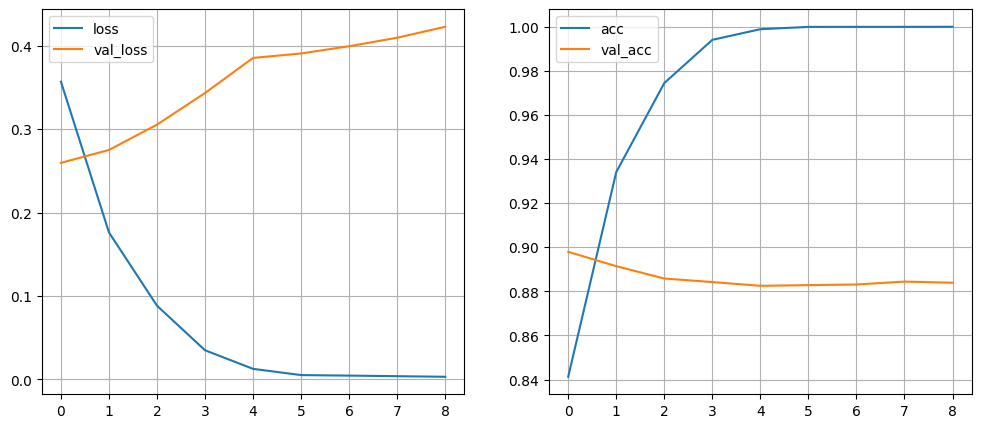

In [21]:
# 학습곡선
hist_dic = history.history

fig, ax = plt.subplots(1, 2, figsize = (12, 5))
ax[0].plot(hist_dic['loss'], label = 'loss')
ax[0].plot(hist_dic['val_loss'], label = 'val_loss')
ax[1].plot(hist_dic['acc'], label = 'acc')
ax[1].plot(hist_dic['val_acc'], label = 'val_acc')
ax[0].legend()
ax[1].legend()
ax[0].grid()
ax[1].grid()
plt.show()

In [22]:
# 검증 데이터 예측 결과 산정
result = model.predict(x_test)
data_count, case_count = result.shape
print("%d개의 검증 데이터가 %d개의 경우의 수를 갖는다." % (data_count, case_count))
result

313/313 [==============================] - 0s 635us/step
10000개의 검증 데이터가 1개의 경우의 수를 갖는다.


array([[0.9525162 ],
       [0.00472501],
       [0.9971835 ],
       ...,
       [0.03859142],
       [0.01528543],
       [0.08128206]], dtype=float32)

In [23]:
# 예측 결과의 1차원 배열화
f_results = result.flatten()
f_results = np.round(f_results, 0)
f_results

array([1., 0., 1., ..., 0., 0., 0.], dtype=float32)

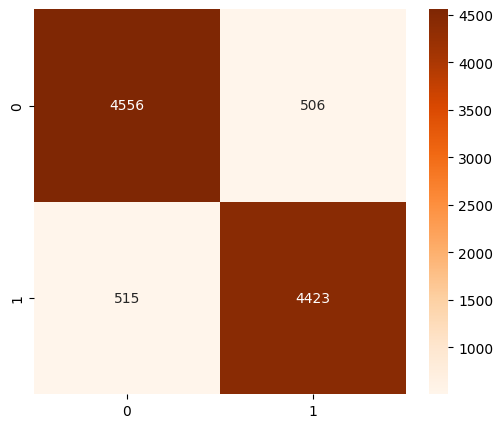

In [26]:
# 혼동행렬
c_mat = confusion_matrix(y_test, f_results)

plt.figure(figsize = (6, 5))
sns.heatmap(c_mat, annot = True, fmt = 'd', cmap = 'Oranges')
plt.show()